In [1]:
import numpy as np
import tensorflow as tf
import PIL as Image
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense
import os
from matplotlib import pyplot as plt

In [2]:
PATH = 'C:/Users/enes_/Documents/GitHub/Datasets/105_classes_pins_dataset'
train_path = PATH + "/train"
test_path = PATH + "/test"
valid_path = PATH + "/valid"

In [3]:
train_path

'C:/Users/enes_/Documents/GitHub/Datasets/105_classes_pins_dataset/train'

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [5]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = datagen.flow_from_directory(train_path,
                                                    batch_size = 200,
                                                    class_mode = 'categorical', 
                                                    target_size = (224, 224),
                                             shuffle=True,
                                             seed=100)    

Found 12271 images belonging to 105 classes.


In [7]:
validation_generator = valid_datagen.flow_from_directory(valid_path,
                                                    batch_size = 200,
                                                    class_mode = 'categorical', 
                                                    target_size = (224, 224),
                                                 shuffle=True,
                                                 seed=100)   

Found 2630 images belonging to 105 classes.


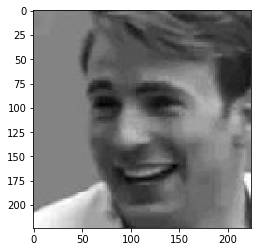

In [8]:
plt.imshow(validation_generator.next()[0][19])

In [9]:
input_shape = train_generator.next()[0].shape[1:]

In [10]:
num_classes = train_generator.next()[1].shape[1]

In [11]:
input_shape

(224, 224, 3)

In [12]:
num_classes

105

In [13]:
num_of_train_samples = 12271
num_of_validation_samples = 2630

In [14]:
model = tf.keras.Sequential()
model.add(Conv2D(16, (64,64),padding='same',activation='relu',input_shape=input_shape,name='conv2d_1'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))
model.add(Conv2D(32, (16,16),activation='relu',name='conv2d_2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(num_classes,activation="softmax"))

In [15]:
optimizer = tf.keras.optimizers.Adam()

In [16]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      196624    
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 112, 112, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 32)        131104    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 48, 48, 32)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dense_1 (Dense)             (None, 105)               2

In [18]:
model.fit(
        train_generator,
        steps_per_epoch=num_of_train_samples/200,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=num_of_validation_samples/200)

Epoch 1/10
 4/61 [>.............................] - ETA: 24:36 - loss: 47.0434 - accuracy: 0.0060

KeyboardInterrupt: 